# Chapter 25: Application of The Instrumental Variable Method: Mendelian Randomization

In [1]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

linearmodels     : 5.3
numpy            : 1.24.3
matplotlib       : 3.7.2
scipy            : 1.11.1
seaborn          : 0.13.0
pandas           : 2.0.3
statsmodels      : 0.14.0
matplotlib_inline: 0.1.6



In [2]:
def fisher_weight(est, se):
    n, d = np.sum(est / se**2), np.sum(1 / se**2)
    return n / d, np.sqrt(1 / d)

In [9]:
bmisbp = pd.read_csv("mr_bmisbp.csv")
bmisbp.columns = [x.replace(".", "_") for x in bmisbp.columns]
bmisbp.head()

,Unnamed: 0,beta_exposure,beta_outcome,se_exposure,se_outcome
0,14,-0.0051,0.003490,0.0066,0.012048
1,15,-0.0254,0.040681,0.0051,0.010801
2,17,0.0077,-0.040866,0.0073,0.012936
3,22,0.0173,0.028683,0.0059,0.010865
4,58,0.0063,-0.009085,0.0095,0.017261


In [20]:
bmisbp["iv"] = bmisbp.eval("beta_outcome / beta_exposure")
bmisbp["se_iv"] = bmisbp.eval("se_outcome / beta_exposure")
bmisbp["se_iv1"] = (
    bmisbp.eval("(se_outcome ** 2 + iv ** 2 * se_exposure ** 2)").apply(np.sqrt)
) / bmisbp["beta_exposure"]

In [18]:
fisher_weight(bmisbp.iv, bmisbp.se_iv)

(0.31727679898885597, 0.05388827130674279)

In [21]:
fisher_weight(bmisbp.iv, bmisbp.se_iv1)

(0.3157600668305777, 0.058937832934585564)

### egger regression

No intercept regression: No exclusion violation allowed

In [26]:
smf.wls(
    "beta_outcome ~ 0 + beta_exposure", data=bmisbp, weights=1 / bmisbp.se_outcome**2
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
beta_exposure,0.3173,0.111,2.869,0.005,0.099,0.536


In [27]:
smf.wls(
    "beta_outcome ~ beta_exposure", data=bmisbp, weights=1 / bmisbp.se_outcome**2
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0001,0.002,0.055,0.957,-0.004,0.004
beta_exposure,0.3173,0.111,2.860,0.005,0.098,0.536


<Axes: xlabel='beta_exposure', ylabel='beta_outcome'>

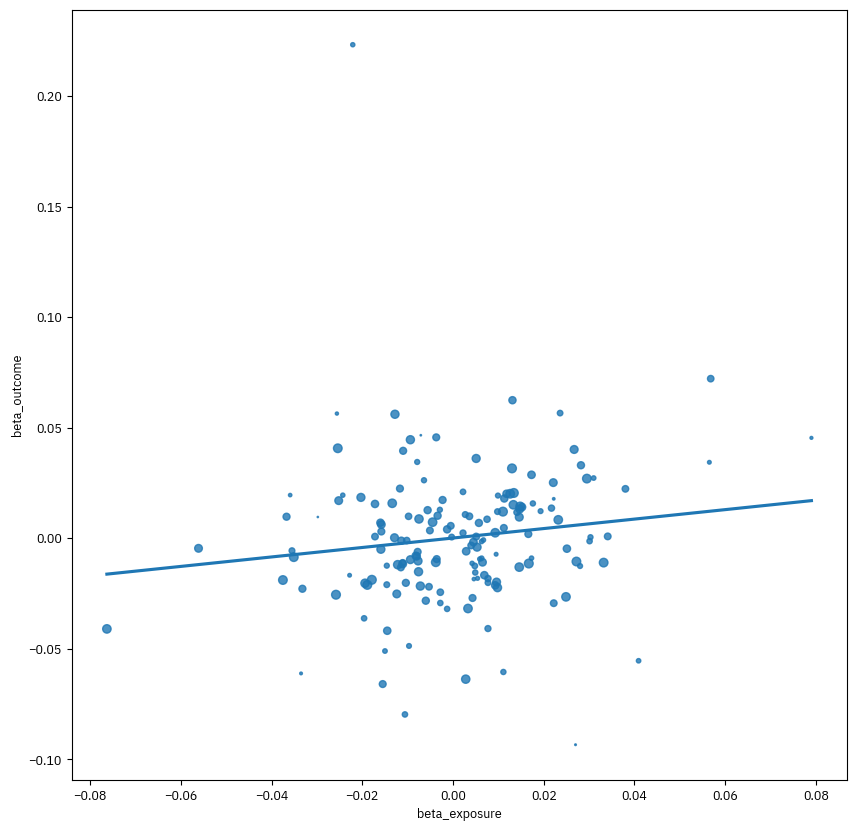

In [39]:
bmisbp["dotsize"] = 1 / bmisbp.se_exposure**2


# Plot miles per gallon against horsepower with other semantics
sns.regplot(
    x="beta_exposure",
    y="beta_outcome",  # size="dotsize",
    data=bmisbp,
    ci=None,
    scatter_kws={"s": bmisbp.dotsize / 1000},
)